<a href="https://colab.research.google.com/github/hflautert/AnomalyDetection/blob/main/AnomaliaSSDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimento de reconhecimento de anomalias em ataque DoS do tipo SSDP.

Fonte de dados:

Rede normal:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/benign/18-05-31.pcap

Rede com ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/AttackAndBenign/18-06-03.pcap

Descrição dos ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/attackinfo.xlsx

Para gerar as estatísticas, os arquivos foram abertos com WireShark, aplicado filtro `SSDP`. Posteriormente gerado dados no menu Statistics, I/O Graph, salvo como csv, nos intervalos de 1 minuto, 10 segundos, e 1 segundo.

Ataques SSDP contabilizados com WireShark = [3](https://github.com/hflautert/AnomalyDetection/blob/main/Prints/WS_SSDP_n.png).

O código fonte foi desenvolvido e executado no [Google Colab](https://colab.research.google.com/).

In [ ]:
# Importando bibliotecas
# Manipulação de matrizes e operações matemáticas de alto nível
import numpy as np
# Geração de gráficos
import matplotlib.pyplot as plt

In [53]:
# Recebe arquivo em array numpy
def prep_csv(arquivocsv):
  array_np = np.loadtxt(arquivocsv, delimiter=',',skiprows=1)
  array_np = array_np[:, 1]
  return array_np

# Visualiza serie de dados em gráfico
def visualiza(serie_dados,u_tempo,c,titulo,tipo):
  plt.plot(serie_dados, color = c )
  plt.title('Número de pacotes '+tipo+' '+titulo)
  plt.xlabel('Intervalo de tempo')
  plt.ylabel('pacotes '+tipo+' / '+u_tempo)
  plt.show()

# Visualizar diferença entre tráfego normal e tráfego com ataques
def visualizamix(serie_dados_a,ca,serie_dados_n,cn,u_tempo,tipo):
  plt.plot(serie_dados_a, color = ca, label = 'Sob ataque')
  plt.plot(serie_dados_n, color = cn, label = 'Em condições normais')
  plt.title('Número de pacotes '+tipo+' em rede IoT')
  plt.xlabel('Intervalo de tempo')
  plt.ylabel('pacotes '+tipo+' / '+u_tempo)
  plt.legend(loc='best')
  plt.show()

def visualiza_alarmes(serie_dados,alarme_pos,alarme_val,u_tempo,tipo,intervalo,cor_pacote,cor_media,media):
  plt.plot(serie_dados[intervalo:], color = cor_pacote, label = tipo)
  plt.plot(media[:], color = cor_media, label = 'Média')
  plt.plot(alarme_pos,alarme_val, 'ro', ms=8, mec='k', label = "Alarme disparado")
  plt.title('Momento(s) de reconhecimento de anomalia')
  plt.xlabel(u_tempo)
  plt.ylabel('Número de pacotes')
  plt.legend()
  plt.grid()
  plt.show()

#
# Funcao para testar o modelo
#
# serie_normal = array de pacotes em qualquer intervalo de tempo do tráfego de rede normal
# serie_ataque = array de pacotes em qualquer intervalo de tempo do tráfego de rede com ataques
# delta_v = variação da media móvel para reconhecer como anomalia ou ataque - quanto menor mais sensível
# inter_mm = intervalo de dados para obter a media móvel - quanto menor mais sensível
# taxa_min = taxa mínima (de pacotes em relacao ao tempo) para considerar a variação, abaixo disso não será avaliado - quanto menor mais sensível
#
def aplica_modelo(serie_normal,serie_ataque,delta_v,inter_mm,taxa_min):
  # Organiza o array em varias linhas (matriz), cada linha conterá a serie de dados para calcular a média móvel
  matriz_normal = np.lib.stride_tricks.sliding_window_view(serie_normal,inter_mm)
  matriz_ataque = np.lib.stride_tricks.sliding_window_view(serie_ataque,inter_mm)

  # Contadores
  cont_ataque = 0 #ataques
  cont_f_ataque = 0 #fasos positivos
  sob_ataque = 0 # caso seja um ataque de crescimento longo, será contabilizado apenas como um ataque
  alarme_normal_pos = [] # Array para registrar momento de ativação dos alarmes do tráfego de rede normal
  alarme_normal_val = [] # Array para registrar valor de ativação dos alarmes do tráfego de rede normal
  alarme_ataque_pos = [] # Array para registrar momento de ativação dos alarmes do tráfego de com ataques
  alarme_ataque_val = [] # Array para registrar valor de ativação dos alarmes do tráfego com ataques
  media_normal = [] # Array para registrar a média de pacotes do tráfego normal
  media_ataque = [] # Array para registrar a média de pacotes do tráfego com ataques

  # Inicia calculo e comparacao das medias moveis
  for i in range(len(matriz_ataque)):
    if i<2:
      pass #sem base para comparacao
    else:
      antpen_media=matriz_ataque[i-2].mean()
      pen_media=matriz_ataque[i-1].mean()
      media_atual=matriz_ataque[i].mean()
      if (antpen_media<taxa_min) and (pen_media<taxa_min) and (media_atual<taxa_min):
        # taxa mínima - registra somente a estabilizacao
        media_ataque.append(taxa_min)
      else:
        media_ataque.append(matriz_ataque[i].mean())
        if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
          # Se a media atual é delta_v maior que a média anterior, e a média anterior é delta_v maior que a antepenúltima, contabiliza ataque
          cont_ataque += 1
          sob_ataque = 1
          # Registra momento do alarme
          alarme_ataque_pos.append(i-2)
          alarme_ataque_val.append(antpen_media)
        if (antpen_media>pen_media) and (pen_media>media_atual):
          sob_ataque = 0 # Media em queda, desarma sob ataque - para contabilizar novos ataques
  # Desarma flag para avaliar o tráfego de rede normal
  sob_ataque = 0
  for i in range(len(matriz_normal)):
    if i<2:
      pass #sem base para comparacao
    else:
      antpen_media=matriz_normal[i-2].mean()
      pen_media=matriz_normal[i-1].mean()
      media_atual=matriz_normal[i].mean()
      if (antpen_media<taxa_min) and (pen_media<taxa_min) and (media_atual<taxa_min):
        # taxa mínima - registra somente a estabilizacao
        media_normal.append(taxa_min)
      else:
        media_normal.append(matriz_normal[i].mean())
        if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
          # Se a media atual é delta_v maior que a média anterior, e a média anterior é delta_v maior que a antepenúltima, contabiliza ataque
          cont_f_ataque += 1
          sob_ataque = 1
          # Registra momento do alarme
          alarme_normal_pos.append(i-2)
          alarme_normal_val.append(antpen_media)
        if (antpen_media>pen_media) and (pen_media>media_atual):
          sob_ataque = 0 # Media em queda, desarma sob ataque - para contabilizar novos ataques

  return cont_ataque,cont_f_ataque,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque

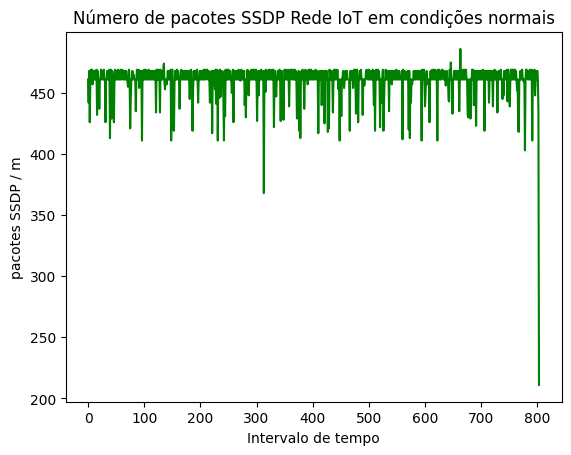

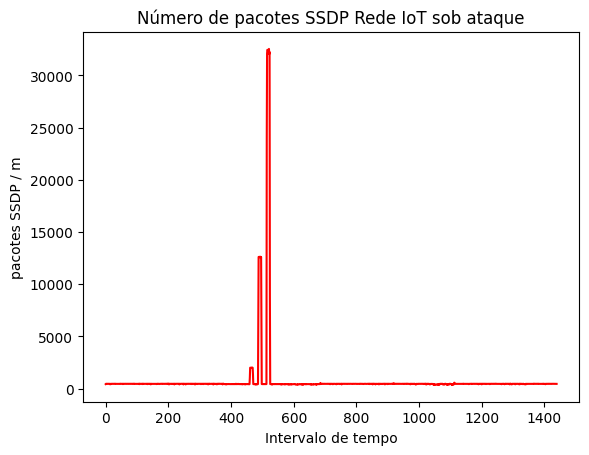

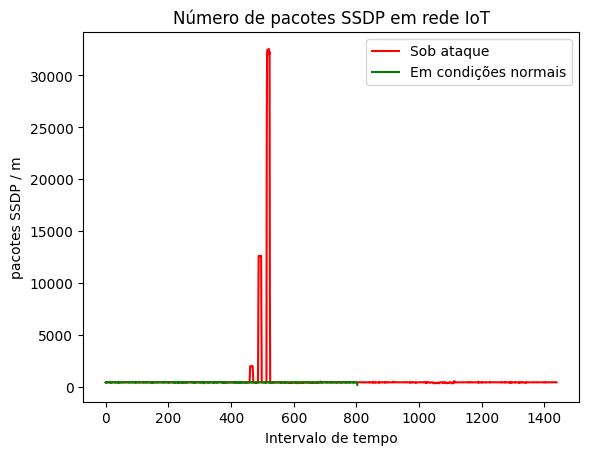

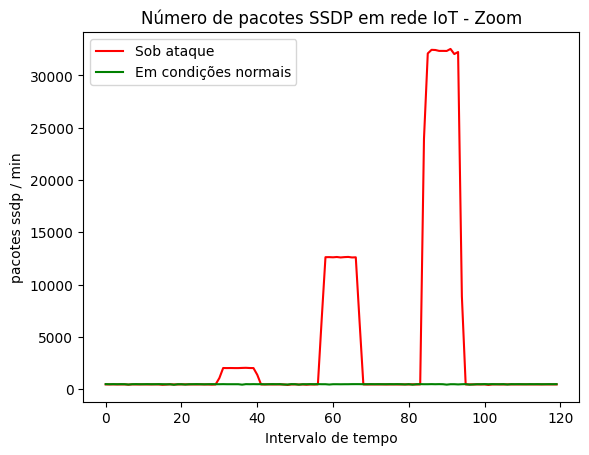

In [48]:
# Carregando dados

dados_normal_1m = prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_ssdp_1m.csv")
dados_normal_10s = prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_ssdp_10s.csv")
dados_normal_1s = prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_ssdp_1s.csv")

dados_ataque_1m = prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-03_ssdp_1m.csv")
dados_ataque_10s = prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-03_ssdp_10s.csv")
dados_ataque_1s = prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-03_ssdp_1s.csv")

tipo_dos_pacotes='SSDP'

visualiza(dados_normal_1m,'m','g','Rede IoT em condições normais',tipo_dos_pacotes)
visualiza(dados_ataque_1m,'m','r','Rede IoT sob ataque',tipo_dos_pacotes)
visualizamix(dados_ataque_1m,'r',dados_normal_1m,'g','m',tipo_dos_pacotes)

# Vizualização otimizada com zoom na janela de ataque de 1, 10 e 100 pcts/s
v_dados_normal_1m = dados_normal_1m[430:550]
v_dados_ataque_1m = dados_ataque_1m[430:550]

# Unindo linhas
plt.plot(v_dados_ataque_1m, color = 'r', label = "Sob ataque")
plt.plot(v_dados_normal_1m, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes SSDP em rede IoT - Zoom')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes ssdp / min')
plt.legend()
plt.show()

Total de ataques identificados: 3


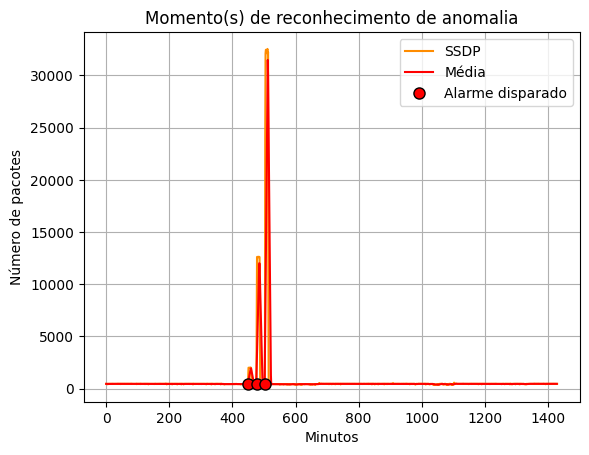

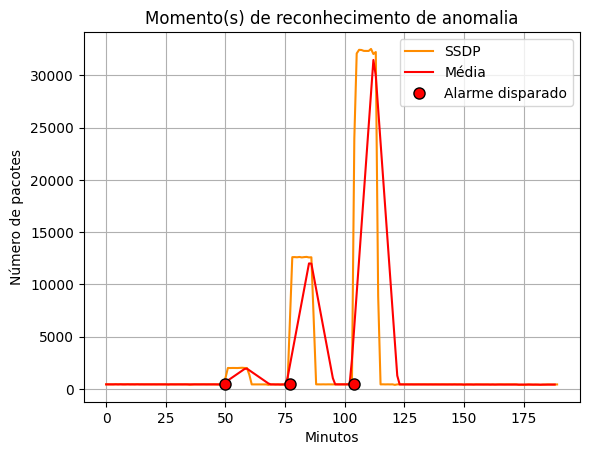

Falsos positivos: 0


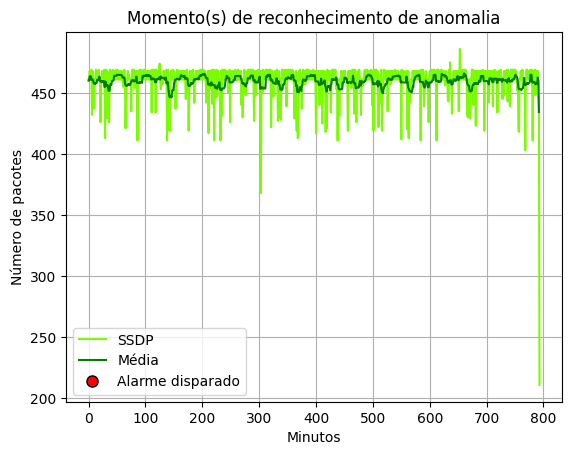

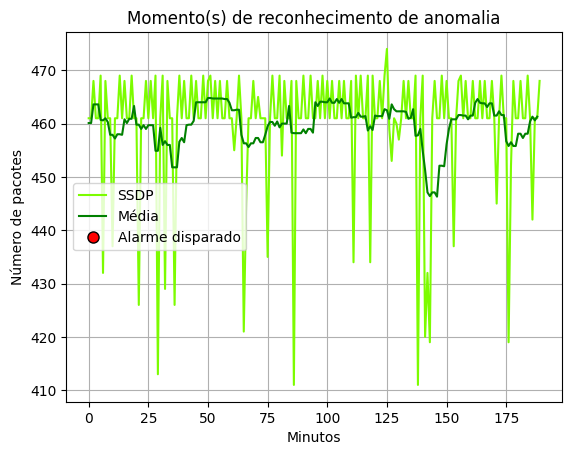

In [54]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_1m
dados_ataque=dados_ataque_1m
unidade_de_tempo='Minutos'
delta=1.1
intervalo=10
taxa_minima=100

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[400:600]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[:200]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 3


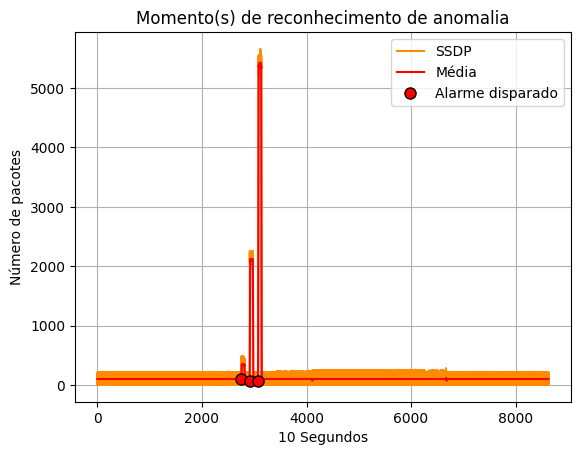

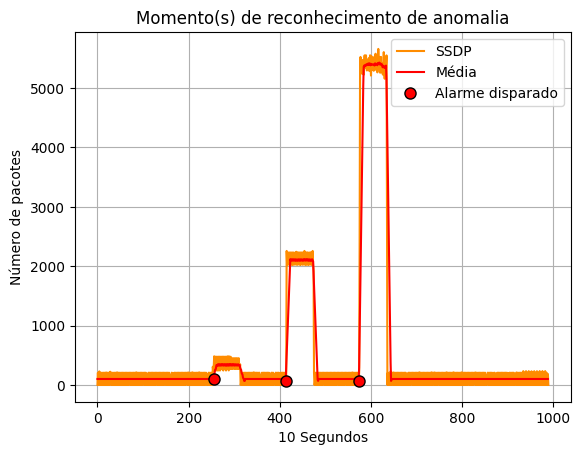

Falsos positivos: 0


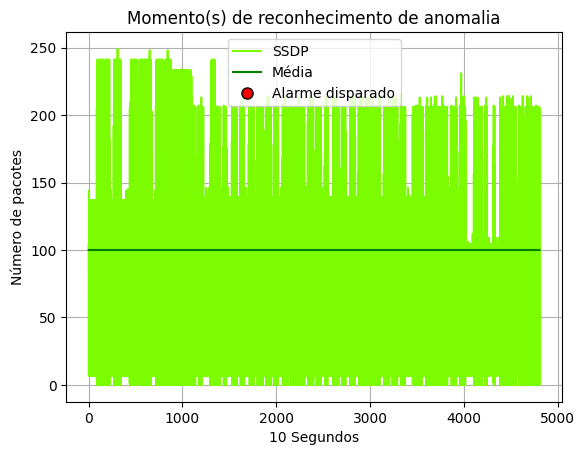

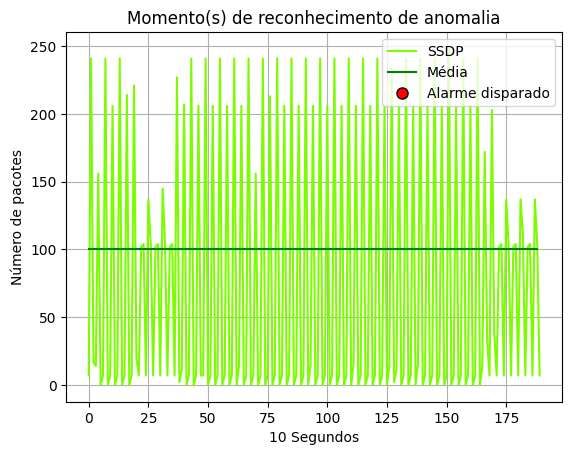

In [61]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_10s
dados_ataque=dados_ataque_10s
unidade_de_tempo='10 Segundos'
delta=1.1
intervalo=10
taxa_minima=100
##

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[2500:3500]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[500:700]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 3


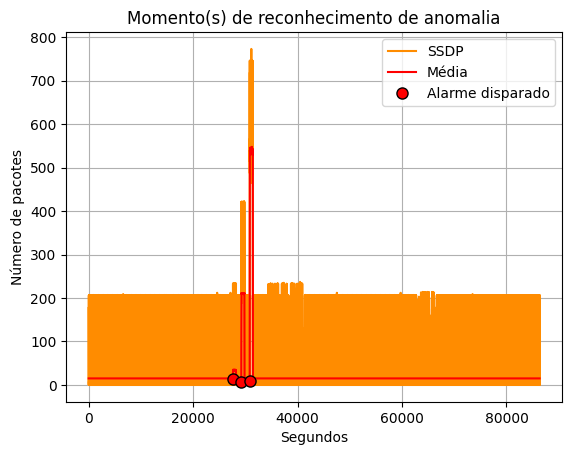

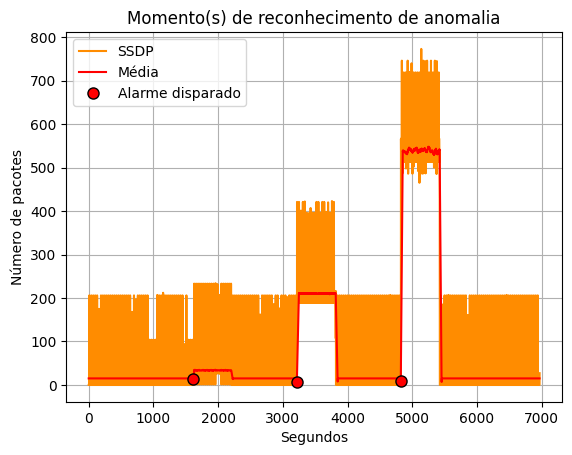

Falsos positivos: 0


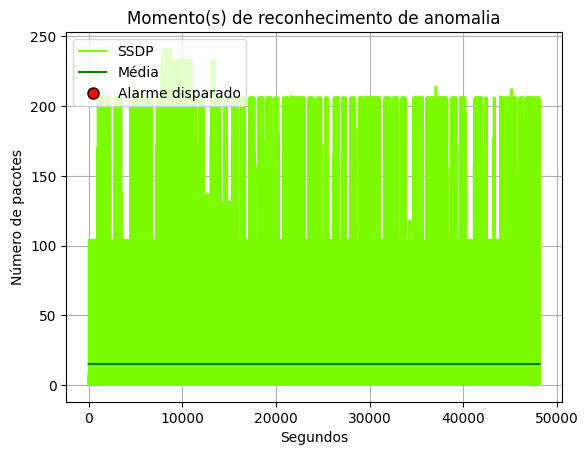

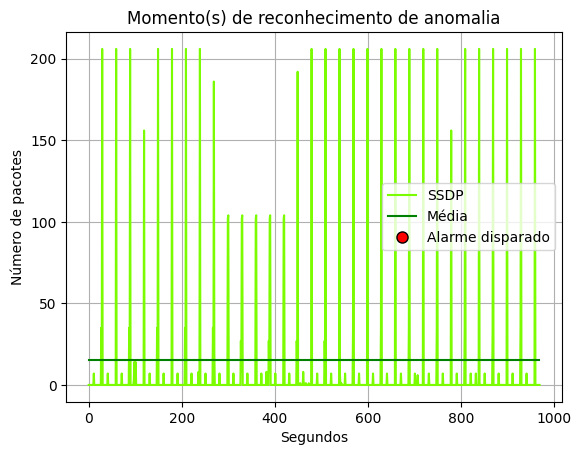

In [59]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_1s
dados_ataque=dados_ataque_1s
unidade_de_tempo='Segundos'
delta=1.05
intervalo=30
taxa_minima=15
##

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[26000:33000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[5000:6000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)